In [1]:
# Importar librerias
import requests                    
import pandas as pd
import time             
import matplotlib.pyplot as plt    
import seaborn as sns               
import numpy as np                  
import datetime
import json
from bs4 import BeautifulSoup
from selenium import webdriver
import re
import geopandas as gpd                     
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.colors as colors

## "Estados Unidos."

Los datos sísmicos se descargaron a través de [USGS](https://earthquake.usgs.gov/fdsnws/event/1/) (El Servicio Geologico de los Estados Unidos ).

El analisis se realiza en un intervalo de inicio el 01 de enero de 2023 y fin el 11 de mayo de 2023, o sea en un periodo de 130 días.

In [ ]:

periodo_en_dias = (datetime.datetime(2023,5,11) - datetime.datetime(2023,1,1)).days
print('El periodo en días es igual a',periodo_en_dias,'días')

El periodo en días es igual a 130 días


Realizar la extraccion y creacion del DataFrame desde el enlace.

In [77]:
    
def extraccion_eeuu():
    
    eeuu = 'https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime=2023-01-01%2000:00:00&endtime=2023-05-11%2023:59:59&maxlatitude=50&minlatitude=24.6&maxlongitude=-65&minlongitude=-125&minmagnitude=1&orderby=time-asc'

    # Hacemos un request porque hay json anidados
    eeuu = requests.get(eeuu).json()
    # el diccionario de features es el que tiene la infomación
    eeuu = pd.json_normalize(eeuu, record_path =['features'])
    return eeuu

eeuu = extraccion_eeuu()

Visualizar los primeros elementos del DataFrame.

In [73]:
eeuu.tail()

,date,time,magnitude,depth,latitude,longitude
10947,2023-05-11,20:30:17,2.57,6.64,40.212500,-121.086500
10948,2023-05-11,20:34:53,2.43,3.36,40.205667,-121.117500
10949,2023-05-11,20:38:30,2.66,7.39,40.204167,-121.106167
10950,2023-05-11,20:45:15,2.51,5.58,40.222000,-121.161833
10951,2023-05-11,20:49:15,2.20,6.04,37.990000,-118.663833


_Transformacion._

Cambiar el nombre de las columnas y quitar properties de los nombres de columnas.

In [54]:
def cambiar_quitar(pais):

    columnas = [p.replace('properties.', '') for p in pais.columns.to_list()]
    new_names = dict(zip(pais.columns.to_list(), columnas))

    pais = pais.rename(new_names, axis='columns')

    return pais

eeuu = cambiar_quitar(eeuu)

Determinar el significado de cada variable.

El significado de las 30 variables se ubica en el siguiente [link](https://earthquake.usgs.gov/data/comcat/data-eventterms.php).

La siguiente grafica determina que existen valores faltantes para las variables __tz__, __felt__, __cdi__, __mmi__ y __alert__.

Text(0.5, 1.0, 'Porcentaje de datos por variable')

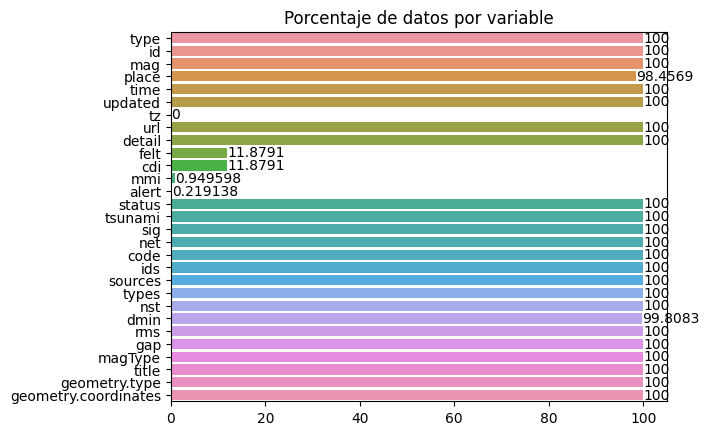

In [55]:
def datos_faltantes(pais):
    ax = sns.barplot(x = (pais.notnull().sum()*100/pais.shape[0]).values, y = pais.columns)
    ax.bar_label(ax.containers[0])
    return plt.title('Porcentaje de datos por variable')

datos_faltantes(eeuu)

In [58]:
print('El total de sismos en 130 días de Estados Unidos es', eeuu.shape[0])
print('La menor magnitud registrada es', eeuu.mag.min())
print('La mayor magnitud registrada es',eeuu.mag.max())

El total de sismos en 130 días de Estados Unidos es 10952
La menor magnitud registrada es 1.0
La mayor magnitud registrada es 5.48


Eliminar variables innecesarias para el modelo.

In [59]:
def eliminar_variables(pais):
    variables = ['type', 'id', 'updated', 'tz', 'url', 'detail', 'felt', 'cdi', 'mmi', 'alert', 'status', 
            'tsunami', 'sig', 'net', 'code', 'ids', 'sources', 'types' , 'nst', 'dmin', 'rms', 
            'gap', 'magType', 'type', 'title', 'geometry.type'] 

    pais = pais.drop(variables, axis='columns')

    return pais

eeuu = eliminar_variables(eeuu)

KeyError: "['type', 'id', 'updated', 'tz', 'url', 'detail', 'felt', 'cdi', 'mmi', 'alert', 'status', 'tsunami', 'sig', 'net', 'code', 'ids', 'sources', 'types', 'nst', 'dmin', 'rms', 'gap', 'magType', 'type', 'title', 'geometry.type'] not found in axis"

Separar las variables de coordenadas en longitud, latitud y profundidad.

In [60]:
def sep_coordenadas(pais):
    pais.rename({'geometry.coordinates':'coordinates'}, axis='columns', inplace=True)
    pais[['longitude','latitude', 'depth']] = pd.DataFrame(pais.coordinates.tolist(), index= pais.index)
    pais.drop('coordinates',axis=1, inplace= True)
    return pais

sep_coordenadas(eeuu)

,mag,place,time,longitude,latitude,depth
0,1.93,"8km ESE of Piru, CA",1672534824860,-118.712500,34.401500,6.66
1,1.00,"18km ESE of Julian, CA",1672539025560,-116.428667,33.012833,6.70
2,2.50,"26 km NW of Stanley, Idaho",1672539177668,-115.200800,44.369500,10.00
3,1.18,"16km N of Borrego Springs, CA",1672539505790,-116.384500,33.400500,3.63
4,1.04,"1km NNW of The Geysers, CA",1672542090120,-122.761498,38.789001,2.51
...,...,...,...,...,...,...
10947,2.57,"3km SSW of East Shore, CA",1683847817670,-121.086500,40.212500,6.64
10948,2.43,"3km E of Prattville, CA",1683848093630,-121.117500,40.205667,3.36
10949,2.66,"4km E of Prattville, CA",1683848310210,-121.106167,40.204167,7.39
10950,2.51,"1km ENE of Almanor, CA",1683848715410,-121.161833,40.222000,5.58


In [61]:
def formato_tiempo(pais):
    def formatear_time(x):

        time = x/1000
        return datetime.datetime.fromtimestamp(time)

    pais.time = pais.time.apply(formatear_time)

    return pais

formato_tiempo(eeuu)

,mag,place,time,longitude,latitude,depth
0,1.93,"8km ESE of Piru, CA",2022-12-31 22:00:24.860,-118.712500,34.401500,6.66
1,1.00,"18km ESE of Julian, CA",2022-12-31 23:10:25.560,-116.428667,33.012833,6.70
2,2.50,"26 km NW of Stanley, Idaho",2022-12-31 23:12:57.668,-115.200800,44.369500,10.00
3,1.18,"16km N of Borrego Springs, CA",2022-12-31 23:18:25.790,-116.384500,33.400500,3.63
4,1.04,"1km NNW of The Geysers, CA",2023-01-01 00:01:30.120,-122.761498,38.789001,2.51
...,...,...,...,...,...,...
10947,2.57,"3km SSW of East Shore, CA",2023-05-11 20:30:17.670,-121.086500,40.212500,6.64
10948,2.43,"3km E of Prattville, CA",2023-05-11 20:34:53.630,-121.117500,40.205667,3.36
10949,2.66,"4km E of Prattville, CA",2023-05-11 20:38:30.210,-121.106167,40.204167,7.39
10950,2.51,"1km ENE of Almanor, CA",2023-05-11 20:45:15.410,-121.161833,40.222000,5.58


Crear variables __date__ y __time_hour__.

In [62]:
def crear_variables_time(pais):
    pais['date'] = pais.time.dt.date
    pais['time_hour'] = pais.time.dt.time
    pais['time_hour'] = pais['time_hour'].apply(lambda x: x.replace(microsecond=0))

    return pais

crear_variables_time(eeuu)

,mag,place,time,longitude,latitude,depth,date,time_hour
0,1.93,"8km ESE of Piru, CA",2022-12-31 22:00:24.860,-118.712500,34.401500,6.66,2022-12-31,22:00:24
1,1.00,"18km ESE of Julian, CA",2022-12-31 23:10:25.560,-116.428667,33.012833,6.70,2022-12-31,23:10:25
2,2.50,"26 km NW of Stanley, Idaho",2022-12-31 23:12:57.668,-115.200800,44.369500,10.00,2022-12-31,23:12:57
3,1.18,"16km N of Borrego Springs, CA",2022-12-31 23:18:25.790,-116.384500,33.400500,3.63,2022-12-31,23:18:25
4,1.04,"1km NNW of The Geysers, CA",2023-01-01 00:01:30.120,-122.761498,38.789001,2.51,2023-01-01,00:01:30
...,...,...,...,...,...,...,...,...
10947,2.57,"3km SSW of East Shore, CA",2023-05-11 20:30:17.670,-121.086500,40.212500,6.64,2023-05-11,20:30:17
10948,2.43,"3km E of Prattville, CA",2023-05-11 20:34:53.630,-121.117500,40.205667,3.36,2023-05-11,20:34:53
10949,2.66,"4km E of Prattville, CA",2023-05-11 20:38:30.210,-121.106167,40.204167,7.39,2023-05-11,20:38:30
10950,2.51,"1km ENE of Almanor, CA",2023-05-11 20:45:15.410,-121.161833,40.222000,5.58,2023-05-11,20:45:15


Eliminar variable __time__.

In [63]:
eeuu.drop('time', axis='columns', inplace=True)

Renombrar las variables.

In [64]:
eeuu.rename({'mag':'magnitude', 'time_hour':'time'}, axis='columns', inplace=True)

Analizar el formato.

In [65]:
eeuu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10952 entries, 0 to 10951
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  10952 non-null  float64
 1   place      10783 non-null  object 
 2   longitude  10952 non-null  float64
 3   latitude   10952 non-null  float64
 4   depth      10952 non-null  float64
 5   date       10952 non-null  object 
 6   time       10952 non-null  object 
dtypes: float64(4), object(3)
memory usage: 599.1+ KB


Text(0.5, 1.0, 'Cantidad de valores únicos por variable')

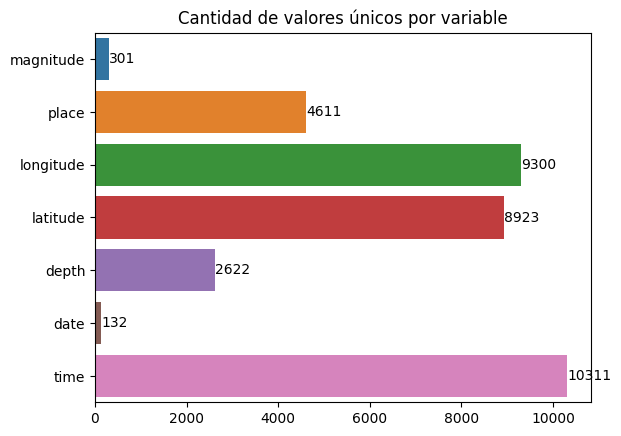

In [66]:
def valor_unico(pais):
    ax = sns.barplot(x = pais.nunique().values, y = pais.columns)
    ax.bar_label(ax.containers[0])
    return plt.title('Cantidad de valores únicos por variable')

valor_unico(eeuu)

El mapa de correlaciones determina que no existe correlacion lineal entre variables.

Text(0.5, 1.0, 'Mapa de correlacion')

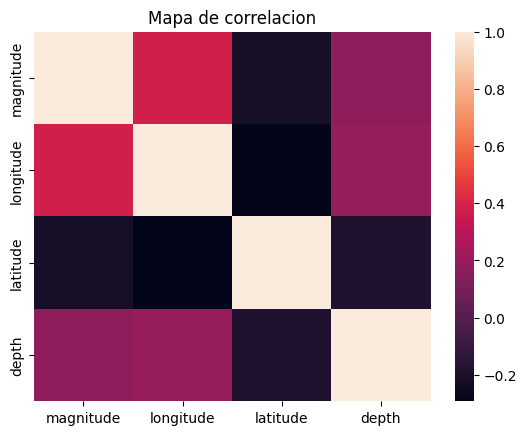

In [42]:
def mapa_correlacion(pais):

    sns.heatmap(pais.corr(numeric_only=True))
    return plt.title('Mapa de correlacion')

mapa_correlacion(eeuu)

Los siguientes graficos determinan la distribucion sismica por region y la magnitude predominante: alrededor de 4.3 grados.

C:\Users\Edwar\AppData\Local\Temp\ipykernel_9728\1994935748.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


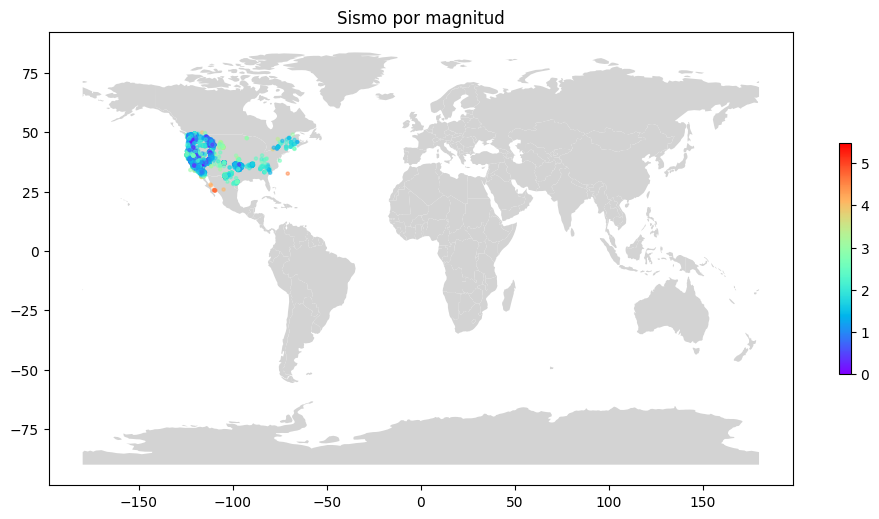

In [43]:

def mapa_sismo(pais):
    # https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    # Escogemos el mapa
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    # Creamos el objeto geodataframe
    crs = 'EPSG:4326'
    geometry = [Point(xy) for xy in zip(pais['longitude'], pais['latitude'])]
    geo_df = gpd.GeoDataFrame(pais, 
                            crs = crs, 
                            geometry = geometry)

    # por magnitud
    fig, ax = plt.subplots(figsize = (12,10))

    world.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

    geo_df.plot(column = 'magnitude', ax=ax, cmap = 'rainbow',
                legend = True, legend_kwds={'shrink': 0.3}, 
                markersize = 5, alpha=0.5)
                
    ax.set_title('Sismo por magnitud')

mapa_sismo(eeuu)

C:\Users\Edwar\AppData\Local\Temp\ipykernel_9728\4281014579.py:3: UserWarning: 
The palette list has fewer values (10) than needed (6105) and will cycle, which may produce an uninterpretable plot.
  return sns.displot(pais, x="magnitude",hue='place',multiple="stack",kde=True,palette=sns.color_palette('bright')[:13])


KeyboardInterrupt: 

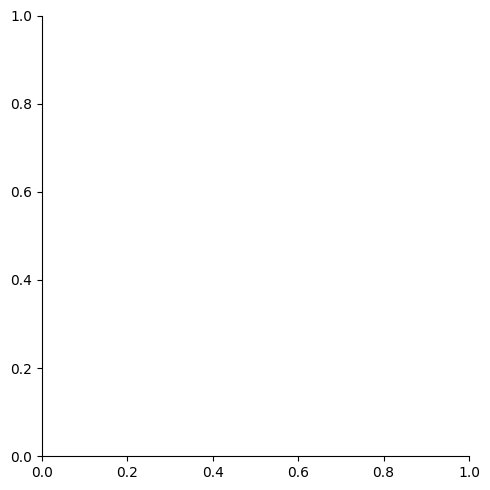

In [44]:

def magnitud_region(pais):
    
    return sns.displot(pais, x="magnitude",hue='place',multiple="stack",kde=True,palette=sns.color_palette('bright')[:13])

magnitud_region(eeuu)

Eliminar variable __place__.

In [67]:
eeuu.drop('place', axis='columns', inplace=True)

Ordenar variables.

In [68]:
def ordenar_vaiables(pais):

    pais = pais[['date','time',	'magnitude','depth','latitude','longitude']]
    return pais

eeuu = ordenar_vaiables(eeuu)

In [69]:
eeuu.tail()

,date,time,magnitude,depth,latitude,longitude
10947,2023-05-11,20:30:17,2.57,6.64,40.212500,-121.086500
10948,2023-05-11,20:34:53,2.43,3.36,40.205667,-121.117500
10949,2023-05-11,20:38:30,2.66,7.39,40.204167,-121.106167
10950,2023-05-11,20:45:15,2.51,5.58,40.222000,-121.161833
10951,2023-05-11,20:49:15,2.20,6.04,37.990000,-118.663833


Convertir data frame a json.

Formatear __date__ a strange.

In [70]:
def crear_variables_time(pais):
    
    
    pais['date'] = pais['date'].apply(lambda x: str(x))

    return pais

crear_variables_time(eeuu)

,date,time,magnitude,depth,latitude,longitude
0,2022-12-31,22:00:24,1.93,6.66,34.401500,-118.712500
1,2022-12-31,23:10:25,1.00,6.70,33.012833,-116.428667
2,2022-12-31,23:12:57,2.50,10.00,44.369500,-115.200800
3,2022-12-31,23:18:25,1.18,3.63,33.400500,-116.384500
4,2023-01-01,00:01:30,1.04,2.51,38.789001,-122.761498
...,...,...,...,...,...,...
10947,2023-05-11,20:30:17,2.57,6.64,40.212500,-121.086500
10948,2023-05-11,20:34:53,2.43,3.36,40.205667,-121.117500
10949,2023-05-11,20:38:30,2.66,7.39,40.204167,-121.106167
10950,2023-05-11,20:45:15,2.51,5.58,40.222000,-121.161833


In [71]:
eeuu_json = eeuu.to_json(orient = 'records')

Guardar datos en un archivo json.

In [72]:
with open('datos_eeuu.json', 'w') as f:
    f.write(eeuu_json)